# Milestone 3 - Media coverage of violent events in war zone

In the current era of mass communication, globalization, on-demand video, social medias and instant messaging, media and newspapers (increasingly digital) have a central position.

Nowadays, news instantly travel the globe, and they travel *massively*.

The 2000s have been a time of war, but mostly war located far from 'developed' countries, many important conflicts happened such as Iraq's war, Syria's war, the Arab Spring, September 11th or Mali's war. Many of these conflicts involved NOTA's countries or Russia, these countries are often at war but by long distance. 

This Modern media coverage of these conflicts is at the center of many ethical discussions. The recurrent critisism is that newspapers focus their article topics arbitrarily and often have a debatable sense of priority.

If such a claim were true, the consequences could be significant given the importance of modern medias in inhabitants of western countries daily lives. A lack of coverage of a conflict by newspapers could make people think that the situation in countries at war improved when it has not.

## 1. Hypothesis and Data retrieval

### **Our hypothesis is that there exists a loss of interest of medias over time for some countries even when this country is still at war and that this coverage is biased towards western countries' views and in particular the U.S.A.**

To achieve this we chose to use the [**GDELT 2.0 dataset**](https://www.gdeltproject.org/). 

We chose to analyse the media coverage of violent events in some specific countries (Afghanistan, Syria, Iraq, Pakistan and Mexico) over the years 2000 to 2016.

Among the data provided in the dataset we used :

* *ActionGeo_CountryName*, the 2-character FIPS10-4 country code for the location of the events to get the countries.
* [*EventRootCode*](http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf) 18, 19 and 20 that correspond to the most violent events in the documentation.
* *MonthYear* to have the date (in month and year) of each event
* *Events* that we got from our SQL query as being the number of events per month
* *Articles* from our SQL query as well, being the number of Articles per month

We also chose to extract data from the [**UCDP**](http://ucdp.uu.se/) dataset, we kept only our featured countries and the best estimation given for the number of deaths per year.

## 2. Imports, global names and helper functions

In [786]:
import pandas as pd
import pyarrow.parquet as pq
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sbs
import numpy as np

In [787]:
total_articles_file = 'totart_code181920.csv'
total_events_file = 'totevent_code181920.csv'
ucdp_file = 'ged171.csv'
gdelt_file = 'big_query_2000_2016.csv'
top_events_file = 'top_event_2000_2016.csv'
top_articles_file = 'top_acticles_2000_2016.csv'
years = [2000, 2016]

In [788]:
def read_csv(filename, years=years, year_col='Year'):
    x = pd.read_csv(filename)
    x = x[(x[year_col] >= years[0]) & (x[year_col] <= years[1])]
    return x

In [789]:
def deaths_country(_df, country_name):
    x = _df[_df['Country'] == country_name].drop('Country', axis=1).groupby('Date').sum().reset_index()
    if(country_name == 'Mexico'):
        # We need to artificially add some rows for mexico due to missing (no deaths) data these years
        x = x.append(pd.DataFrame([[2003, 0], [2000, 0], [2001, 0]], columns=['Date', 'Deaths'])).sort_values('Date')
    x['Deaths'] = x['Deaths']
    return x.set_index('Date')

In [790]:
def df_country(_df, country):
    return _df[_df.Country == country].drop('Country', axis=1).set_index(['Date'])

In [791]:
# Plot a barplot of the number od death per year, over the ratio number of article per event per year.
def plot_tendency(country_name,deaths, ratio):
    #global parameters
    fig_height = 12
    fig_weight = 12
    date = np.arange(2000,2017,1,dtype=np.int64) # stop value excluded
    year_xlabel = r"year of study"
    left_axis = r"ratio article/event"
    right_axis = r"number of deaths"    
    
    tendency_title = r"Media Coverage Tendency Over The Number Of Death in "+country_name
    f,ax_ = plt.subplots(sharex=True)
    f.set_figheight(fig_height)
    f.set_figwidth(fig_weight)
    plt.title(tendency_title)
    plt.xlabel(year_xlabel)
    
    ax_.set_xticks(date)
    ax_right = ax_.twinx()

    ax_.bar(date,deaths)
    ax_right.plot(date,ratio,color='r' )

    plt.show()

## 3. Data preprocessing

## 3.1 Processing of the UCDP dataset

### 3.1.1 DataFrame creations

*articles_year* and *events_year* represent the number of articles (resp. events) per year in the world.

In [792]:
articles_year = read_csv(total_articles_file)
events_year = read_csv(total_events_file)

events_year.head()

,Year,NumEvents
21,2000,330047
22,2001,390659
23,2002,344684
24,2003,403647
25,2004,401826


*deaths* represent the number of deaths by country per year

In [793]:
deaths = read_csv(ucdp_file, year_col='year')
deaths = deaths[['year', 'country', 'best']]
deaths.columns = ['Date', 'Country', 'Deaths']

deaths.head()

,Date,Country,Deaths
0,2010,Yemen (North Yemen),2
1,2011,Yemen (North Yemen),0
2,2011,Yemen (North Yemen),0
3,2012,Yemen (North Yemen),5
4,2012,Yemen (North Yemen),5


### 3.1.2 Country separation

Here we create one dataframe per country

In [794]:
deaths_irq = deaths_country(deaths, 'Iraq')
deaths_afg = deaths_country(deaths, 'Afghanistan')
deaths_mex = deaths_country(deaths, 'Mexico')
deaths_pak = deaths_country(deaths, 'Pakistan')

deaths_irq.head()

,Deaths
Date,
2000,185
2001,27
2002,111
2003,7999
2004,4365


## 3.2 Processing of our aggregation of the GDELT dataset

We first tried to get the data from the cluseter but the dataset present on it was a subset of GDELT. Therefore most of the features were missing. To get the location of an event we used at first "Source" and "Target" field that matched the country we were intrested in. But those entries were not consistent.
The full dataset was supposed to have an ActionGeo_Country code which represent the county were the event took place. We were also supposed to have access to features like "MonthYear", "EventRootCode",...

For all those reasons we decided to stop using the cluster and make our query on the full GDELT dataset using the [Google Big Query](https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events)

The sql queries can be found on the repository

### 3.2.1 DataFrame creation

*df* represents our aggregated gdelt data(sub)set

In [795]:
df = pd.read_csv(gdelt_file)
df.columns = ['Country', 'Date', 'EventCode', 'Events', 'Articles']

df.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,26118,558078
1,SY,201608,19,23797,513882
2,SY,201602,19,27567,483618
3,SY,201510,19,27216,469990
4,SY,201612,19,22474,468685


### 3.2.2 Normalization

This part is important. To be able to correctly analyse our data, we need to normalize the number of articles (resp. events) per year in the aggregated gdelt dataset by the total number of articles (resp. events) in the world this year.

This normalization is required, and we discuss in part **3.4** of why it is.

In [796]:
tmp = pd.DataFrame(df['Date'].apply(lambda x: int(x / 100))).rename(columns={'Date': 'Year'})
tmp[['Articles', 'Events']] = df[['Articles', 'Events']]
tmp = tmp.merge(articles_year, how='left').merge(events_year, how='left')
tmp['Articles'] = (tmp['Articles'] / tmp['NumArticles']) * 100
tmp['Events'] = (tmp['Events'] / tmp['NumEvents']) * 100

df_normalized = df.copy()
df_normalized[['Articles', 'Events']] = tmp[['Articles', 'Events']]

tmp.drop(['NumEvents', 'NumArticles', 'Year'], axis=1).head()

,Articles,Events
0,0.523651,0.415809
1,0.482181,0.378857
2,0.453784,0.438877
3,0.487254,0.475321
4,0.439772,0.357795


The data that we get out of our query is the number of Event and the number of Articles aggregated per country, MonthYear and EventCode.
Aggregating the data this way enables us to work on a consise dataset(compared to the original enormous GDELT). However we still keep the different event code and month data separated for further analysis.

In [797]:
df_normalized.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,0.415809,0.523651
1,SY,201608,19,0.378857,0.482181
2,SY,201602,19,0.438877,0.453784
3,SY,201510,19,0.475321,0.487254
4,SY,201612,19,0.357795,0.439772


## 3.3 Separation by country and aggregation per year and event code

In this part, we will create new dataframes that will hold our data aggregated by country and date, while forgetting (for now) the event types.

We will also create a new column, called *Ratio*, that will represent the ratio (in a given country and year) of the number of articles over the number of events (both normalized).

In [798]:
df_grouped = df_normalized.groupby(['Date', 'Country']).sum().drop(['EventCode'], axis=1).sort_index(level=[0,1])

df_merged = df_grouped.reset_index()

irq = df_country(df_merged, 'IZ')
mex = df_country(df_merged, 'MX')
pak = df_country(df_merged, 'PK')
afg = df_country(df_merged, 'AF')
syr = df_country(df_merged, 'SY')

df_merged.head()

,Date,Country,Events,Articles
0,200001,AF,0.059991,0.055892
1,200001,IZ,0.082413,0.085572
2,200001,MX,0.029996,0.024449
3,200001,PK,0.271476,0.308229
4,200001,SY,0.056053,0.044641


Creation of the ratio column.

In [831]:
df_year = df_merged.copy()

df_year['Date'] = df_year['Date'].apply(lambda d: int(d/100))

df_year = df_year.groupby(['Date', 'Country']).sum().reset_index()

df_year['Ratio'] = df_year['Articles'] / df_year['Events'].astype('float')

irq_year1 = df_country(df_year, 'IZ')
mex_year1 = df_country(df_year, 'MX')
pak_year1 = df_country(df_year, 'PK')
afg_year1 = df_country(df_year, 'AF')
syr_year1 = df_country(df_year, 'SY')

df_year.head()

,Date,Country,Events,Articles,Ratio
0,2000,AF,1.250125,1.189615,0.951597
1,2000,IZ,1.133475,1.081540,0.954181
2,2000,MX,0.545377,0.540131,0.990382
3,2000,PK,2.435108,2.653278,1.089594
4,2000,SY,0.422061,0.307500,0.728566


Merging of both dataset informations.

In [800]:
irq_year = deaths_irq.join(irq_year1)
mex_year = deaths_mex.join(mex_year1)
pak_year = deaths_pak.join(pak_year1)
afg_year = deaths_afg.join(afg_year1)

irq_year.head()

,Deaths,Events,Articles,Ratio
Date,,,,
2000,185,1.133475,1.081540,0.954181
2001,27,1.261458,1.265594,1.003279
2002,111,2.016920,2.134456,1.058275
2003,7999,11.818495,13.531332,1.144929
2004,4365,16.028331,17.477858,1.090435


## (3.4 Some plots and describes) ?

In [801]:
irq_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,4459.294118,5.877917,6.881965,1.204209
std,4390.300499,5.285167,5.922287,0.184164
min,27.000000,1.133475,1.081540,0.954181
25%,1407.000000,2.016920,2.669132,1.090435
50%,3521.000000,2.989772,4.015407,1.152550
75%,4609.000000,11.421006,13.139998,1.270181
max,15010.000000,16.028331,17.667749,1.723770


In [802]:
mex_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,1115.764706,0.789975,0.865110,1.031838
std,1041.491450,0.414106,0.610797,0.156330
min,0.000000,0.390468,0.329407,0.834902
25%,187.000000,0.545377,0.538515,0.928847
50%,776.000000,0.719894,0.769108,0.990382
75%,1699.000000,0.904105,1.011923,1.121169
max,3313.000000,2.060336,2.850549,1.383536


In [803]:
pak_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,2290.882353,4.303978,4.271609,0.971546
std,2437.833974,1.588272,1.952577,0.104199
min,1.000000,2.435108,2.291816,0.761766
25%,241.000000,3.134959,3.023198,0.922973
50%,1366.000000,3.756261,3.445359,0.965777
75%,3540.000000,4.901301,4.973208,1.018896
max,7460.000000,8.699440,9.783372,1.124598


In [804]:
afg_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,7038.176471,4.282732,4.832385,1.124671
std,5235.884622,1.817332,2.146847,0.131986
min,817.000000,1.250125,1.189615,0.951597
25%,4982.000000,2.306291,2.777030,1.021591
50%,6499.000000,4.403277,4.637052,1.051623
75%,7822.000000,6.129028,6.651882,1.244709
max,18707.000000,6.903857,8.516913,1.386885


## 3.4 Data inconsistencies and points to be careful of

In this section, we'll detail some issues and important points to keep in minds regarding the data. 

During the processing stage, we found several such issues that we needed to address to make the reader aware of the potential problems is this study.

### 3.4.1 UCDP dataset problems

Merging datasets coming from different sources must always be done carefuly. The UCDP dataset has proved useful, allowing us to add information on casualities by year in different countries. However, we noted several problems.

First, some parts of the data are suspicously missing. For instance in the U.S. only 3 events in the 2000-2016 time frame (including the world trade center terrosist attack) are recorded, even though numerous mass shooting happen every year in this country.

We also found that Syria data is completely blank, which prevented us to do an analysis of Syria similar to the other countries.

Overall, the data seem quite inconsistent, Mexico casualities for example are at 0 in 2000, 2001 and 2003 but we don't know if that's really the case or if the data is simply missing.

### 3.4.2 Increase of data quantity over time and scale issues

During the retrieval of the GDELT dataset, we noted that the quantity of articles and events (and data in general), increases drastically over the years. We suspect that is due to the project's inscreasing maturity, the improvement in data retrieval techniques, and the huge increase in news sources (e.g. via internet).

Below you can find the table that show the number of articles and events over the years and the corresponding barplot.

In [805]:
articles_events_year = articles_year.merge(events_year).set_index('Year')

articles_events_year

,NumArticles,NumEvents
Year,,
2000,1644230,330047
2001,1952601,390659
2002,1585556,344684
2003,2107287,403647
2004,1991022,401826
2005,1419547,290738
2006,2068638,575386
2007,5241264,1044619
2008,7438908,1259645


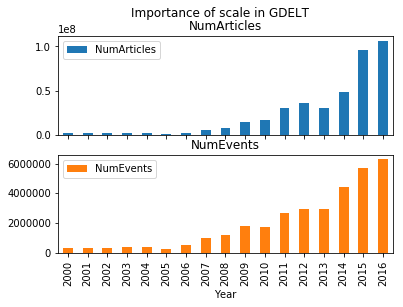

In [806]:
articles_events_year.plot(kind='bar', subplots=True,
                                    title='Importance of scale in GDELT')
plt.show()

In [807]:
articles_events_2000_2016 = articles_events_year.drop([x for x in range(2001, 2016)])

diff = pd.DataFrame(articles_events_2000_2016.loc[2016] / articles_events_2000_2016.loc[2000])

diff

,0
NumArticles,64.817280
NumEvents,19.031392


As you can see, the difference of scale can be huge, almost a factor of 65 (resp.20) for articles (resp. events) between 2000 and 2016.

### 3.4.3 Scale differences between countries

The countries we chose to study (namely Afghanistan, Iraq, Mexico, Pakistan and Syria) face very different conflicts. 

Mexico for example, is mostly subject to gang wars while Iraq inhabitants had to deal with war with the U.S.

This creates huge scale differences between countries, the most obvious one being the casualities. We need to keep this in mind in our study.

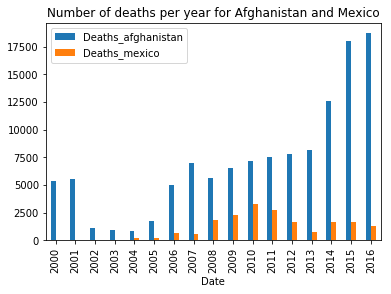

In [808]:
deaths_afg.merge(deaths_mex, how='outer', left_index=True, right_index=True)\
    .rename(columns={'Deaths_x': 'Deaths_afghanistan','Deaths_y': 'Deaths_mexico'})\
    .plot(kind='bar', title='Number of deaths per year for Afghanistan and Mexico')
plt.show()

As we can see on the plot above, taking the example of Iraq and Mexico, the difference of scale in casualities is quite important.

### 3.4.4 GDELT inconsistency in event codes

We found another surprising problem in the GDELT dataset, it seems that the coverage of very serious events (e.g. mass shootings) is inconsistent in the data.

The event code 20, supposed to be the worst events, have a surprisingly low articles/events ratio.

### 3.4.5 Bias in the number of articles depending on countries

Lastly, we want to bring the reader's attention towards the articles bias we found in GDELT. It seems that the number of articles by country is highly biased towards the U.S.A. Our hypothesis is that most article sources actually come from the U.S., hence the important coverage of U.S. and neighbouring countries (e.g. Mexico).

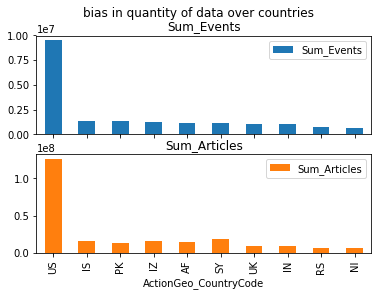

In [809]:
te = pd.read_csv(top_events_file).sort_values('Sum_Events', ascending=False)
ta = pd.read_csv(top_articles_file).sort_values('Sum_Articles', ascending=False)

te.merge(ta).set_index("ActionGeo_CountryCode").head(10).plot(kind='bar', subplots=True, 
                                        title='bias in quantity of data over countries')
plt.show()

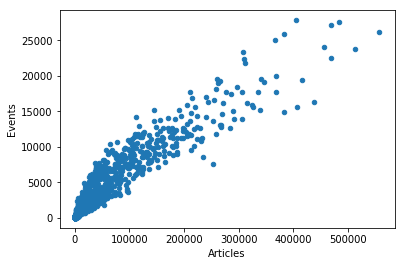

In [810]:
df.plot(kind='scatter', x='Articles', y='Events')

As we can see on the plot above of the 10 countries with the most data, the difference of scale is very high but most importantly, it is only high between the U.S. and other countries, hence our hypothesis.

## 4. Analysis

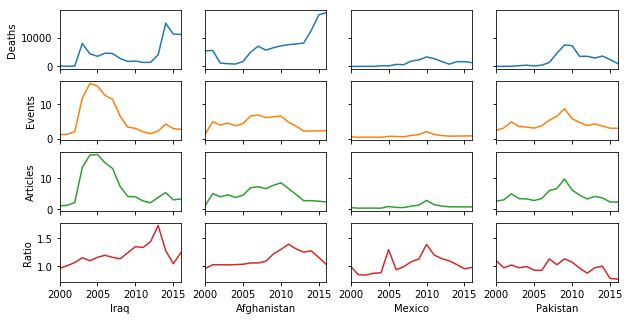

In [811]:
f, mosaic = plt.subplots(4, 4, figsize=(10, 5), sharex=True, sharey='row')

for i, c in enumerate([irq_year, afg_year, mex_year, pak_year]):
    c.plot(ax=mosaic[:, i], subplots=True, legend=False)
    
mosaic[0, 0].set_ylabel('Deaths')
mosaic[1, 0].set_ylabel('Events')
mosaic[2, 0].set_ylabel('Articles')
mosaic[3, 0].set_ylabel('Ratio')
mosaic[3, 0].set_xlabel('Iraq')
mosaic[3, 1].set_xlabel('Afghanistan')
mosaic[3, 2].set_xlabel('Mexico')
mosaic[3, 3].set_xlabel('Pakistan')

plt.show()

## 4.1 Analysis by country per year

# TODO : change plots and discuss them

## Iraq

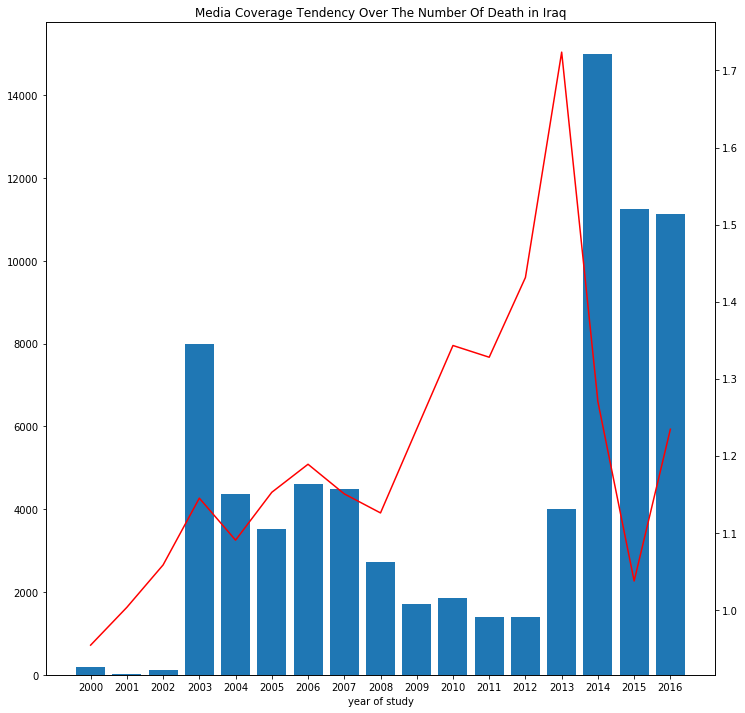

In [812]:
plot_tendency('Iraq', irq_year['Deaths'], irq_year['Ratio'])

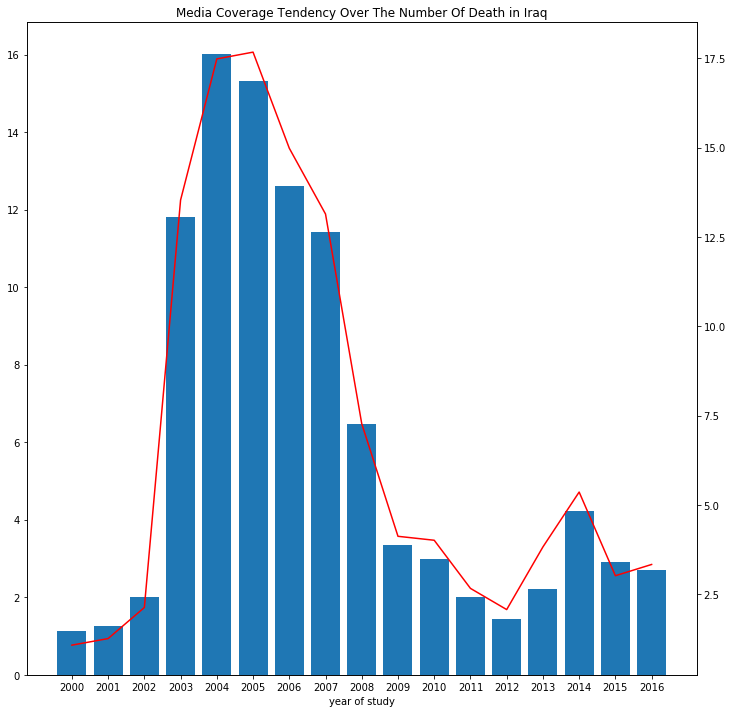

In [813]:
plot_tendency('Iraq', irq_year['Events'], irq_year['Articles'])

## Afghanistan

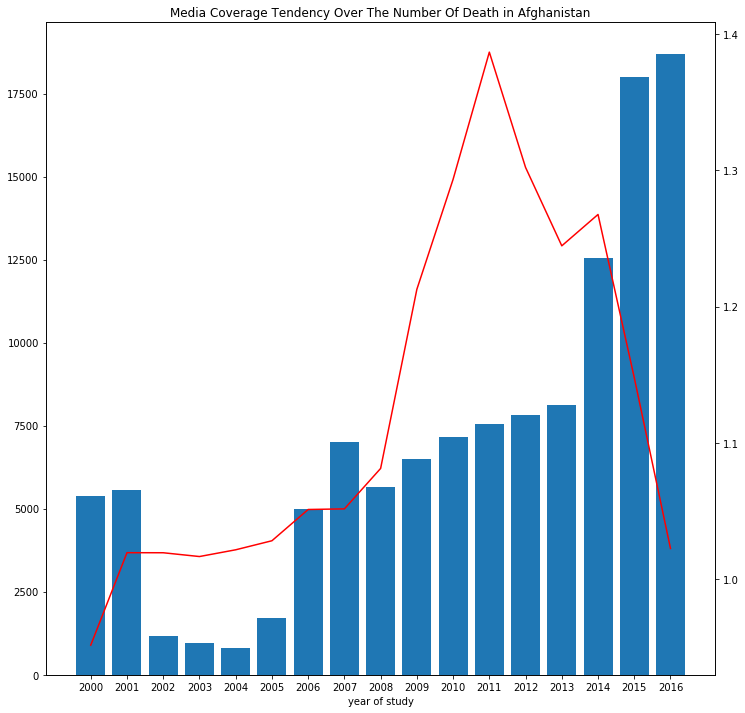

In [814]:
plot_tendency('Afghanistan', afg_year['Deaths'], afg_year['Ratio'])

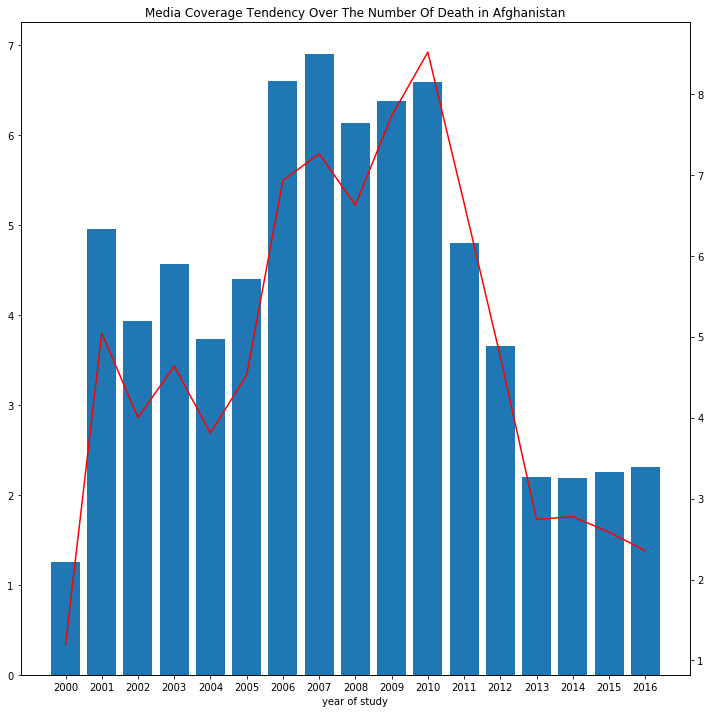

In [815]:
plot_tendency('Afghanistan', afg_year['Events'], afg_year['Articles'])

## Pakistan

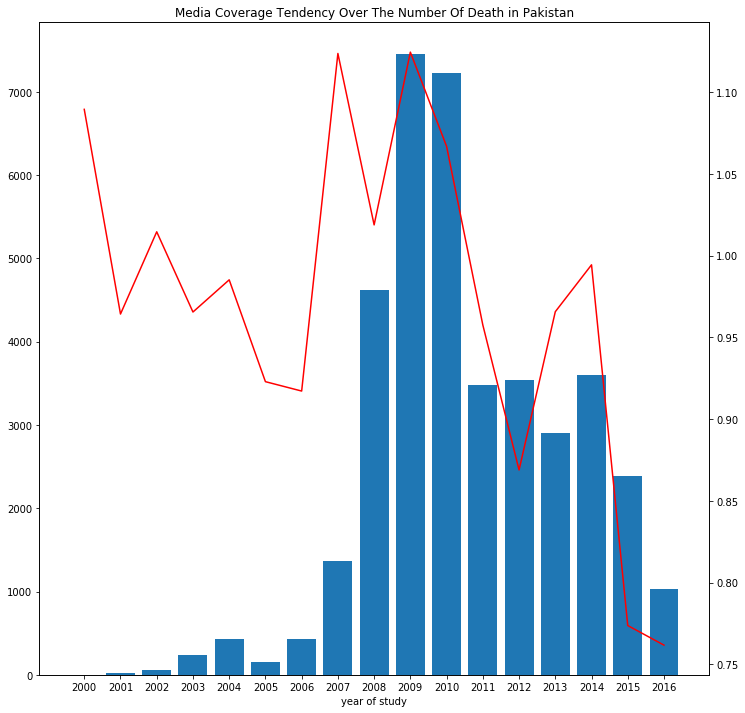

In [816]:
plot_tendency('Pakistan', pak_year['Deaths'], pak_year['Ratio'])

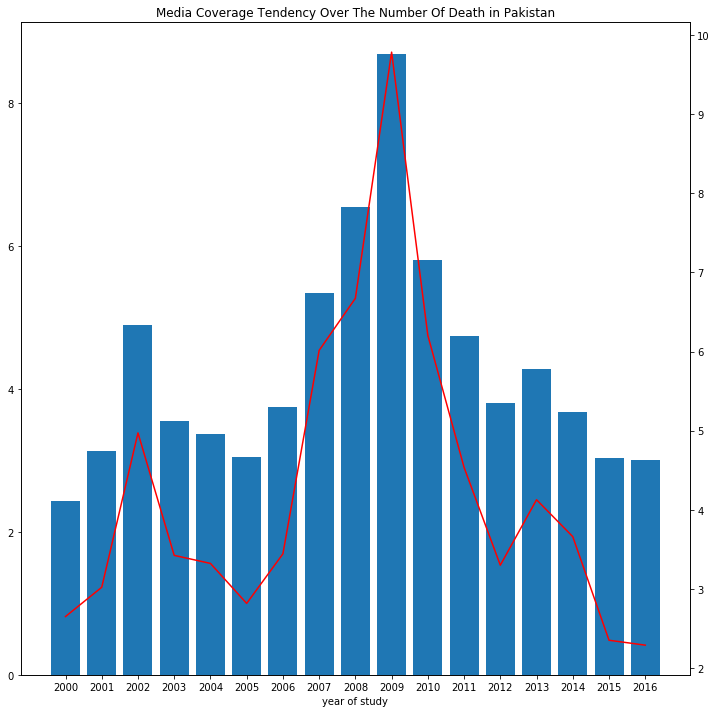

In [817]:
plot_tendency('Pakistan', pak_year['Events'], pak_year['Articles'])

## Mexico

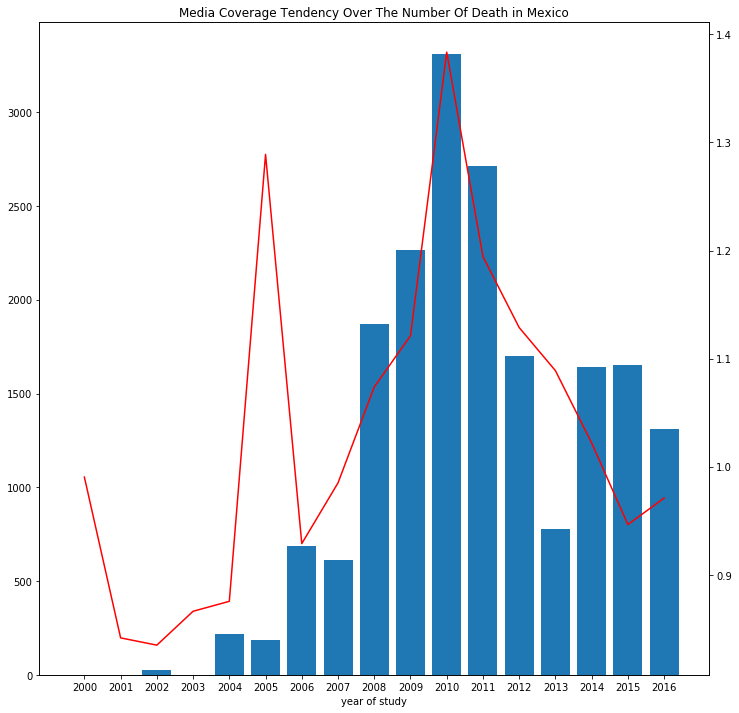

In [818]:
plot_tendency('Mexico', mex_year['Deaths'], mex_year['Ratio'])

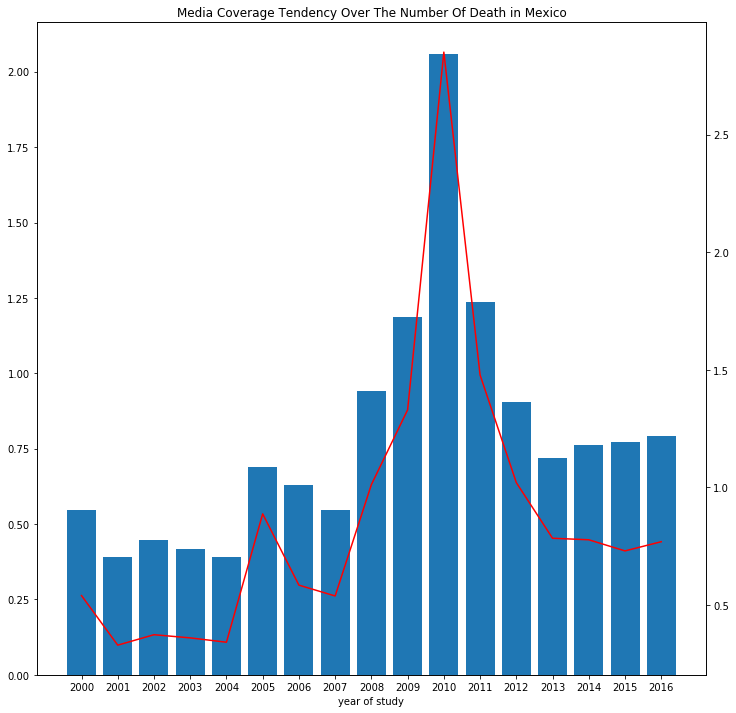

In [819]:
plot_tendency('Mexico', mex_year['Events'], mex_year['Articles'])

## Syria

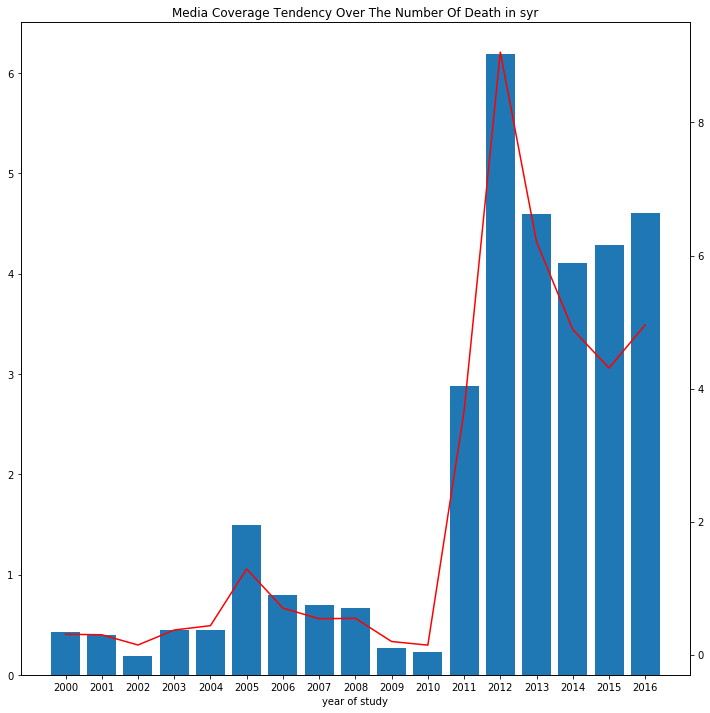

In [820]:
plot_tendency('syr', syr_year1['Events'], syr_year1['Articles'])

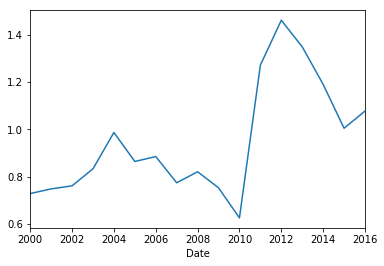

In [821]:
syr_year1['Ratio'].plot()

## 4.2 Analysis by Country per Event Code

In [822]:
df.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,26118,558078
1,SY,201608,19,23797,513882
2,SY,201602,19,27567,483618
3,SY,201510,19,27216,469990
4,SY,201612,19,22474,468685


In [823]:
def df_env_year(_df, country_code):
    x = _df[_df['Country'] == country_code].drop('Country', axis=1)
    x['Date'] = x['Date'].apply(lambda d: int(d / 100))
    return x.groupby(['Date', 'EventCode']).mean()

In [824]:
df_env = df_normalized.copy()

df_env['Ratio'] = df_env['Articles'] / df_env['Events'].astype('float')

df_env.drop(['Articles', 'Events'], axis=1, inplace=True)

irq_ev = df_env_year(df_env, 'IZ')
mex_ev = df_env_year(df_env, 'MX')
afg_ev = df_env_year(df_env, 'AF')
pak_ev = df_env_year(df_env, 'PK')
syr_ev = df_env_year(df_env, 'SY')

## Iraq

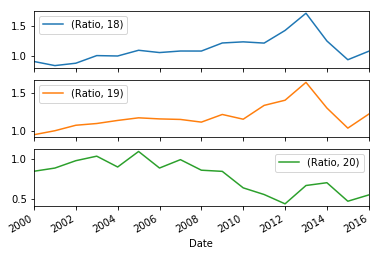

In [825]:
irq_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

## Afghanistan

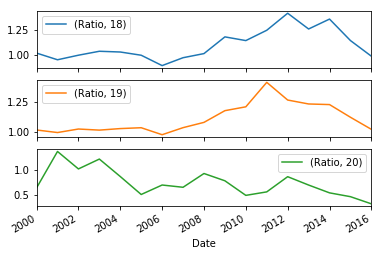

In [826]:
afg_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

## Pakistan

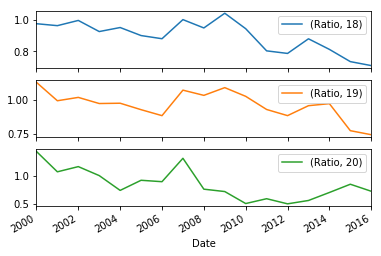

In [827]:
pak_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

## Mexico

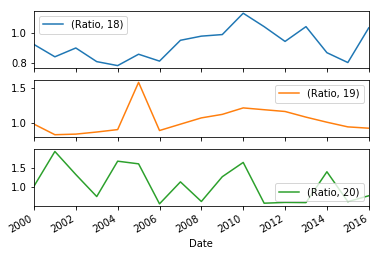

In [828]:
mex_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

## Syria

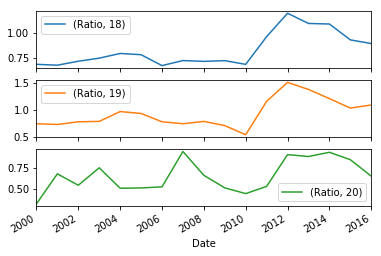

In [829]:
syr_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

As we can see, the type of the events (18, 19 or 20) seems not to influence too much the final ratio between the number of events (i.e. each event has a relatively similar curve shape). This means that our choice of events is sound and can be used without worrying too much about event importance.

## 5. Results